In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import probability_kernels as pk
import scipy.stats as st

In [2]:
import imp
imp.reload(pk);

### Peason data

In [3]:
dff = pd.read_csv('data/pearson-lee-daughters.csv')
xf = dff.Mheight.to_numpy()
yf = dff.Dheight.to_numpy()

dfm = pd.read_table('data/pearson-lee-sons.txt')
xm = dfm.Father.to_numpy()
ym = dfm.Son.to_numpy()

In [4]:
matrices_p = [None] * 3

matrices_p[0] = pk.get_matrix_data(xf, yf)
matrices_p[1] = pk.get_matrix_data(xm, ym)
matrices_p[2] = pk.get_matrix(r=0.54, rs=0.96, num_iters=1_000_000, low_round=6)
# Pearson male is exactly the same: pk.get_matrix(r=0.51, rs=0.89)

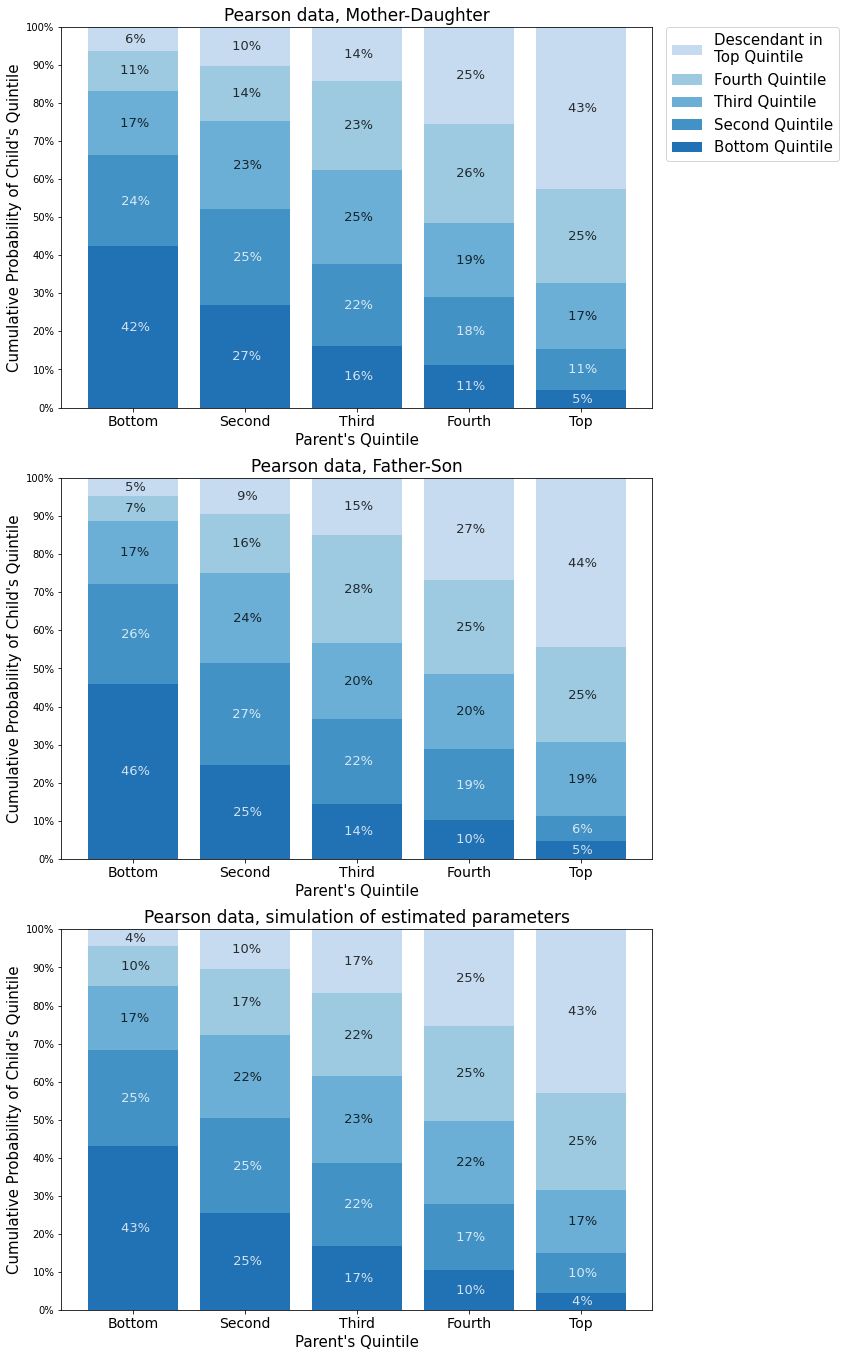

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(13*1*0.95*0.75, 8*3/0.95*0.75))

titles_p = ['Pearson data, Mother-Daughter', 'Pearson data, Father-Son', 
            'Pearson data, simulation of estimated parameters']
for i in range(3):
    pk.plot_ax(ax=axes.ravel()[i], matrix=matrices_p[i], i=0, 
               title=titles_p[i], title_loc='center', child=True)

plt.tight_layout()
legend = ['Descendant in\nTop Quintile', 'Fourth Quintile', 
          'Third Quintile', 'Second Quintile', 'Bottom Quintile']
fig.legend(legend, bbox_to_anchor=(1.27, 0.9805), fontsize=15)   
plt.savefig('latex/figures/quintile-pearson.png', dpi=300)
plt.show()

### Multigenerational mobility, standard parameters

In [6]:
r = 0.5
rs = pk.stable_rs(r)

num_steps = 6

matrices = [None] * num_steps
print('r_s =', round(rs, 5))

r_s = 0.86603


In [7]:
%%time
for i in range(num_steps):
    matrices[i] = pk.get_matrix(r=r, rs=rs, n=i+1, num_iters=1_000_000, low_round=6,
                            n_subs0=5, n_subs1=5)

CPU times: user 15.8 s, sys: 5.23 s, total: 21 s
Wall time: 21 s


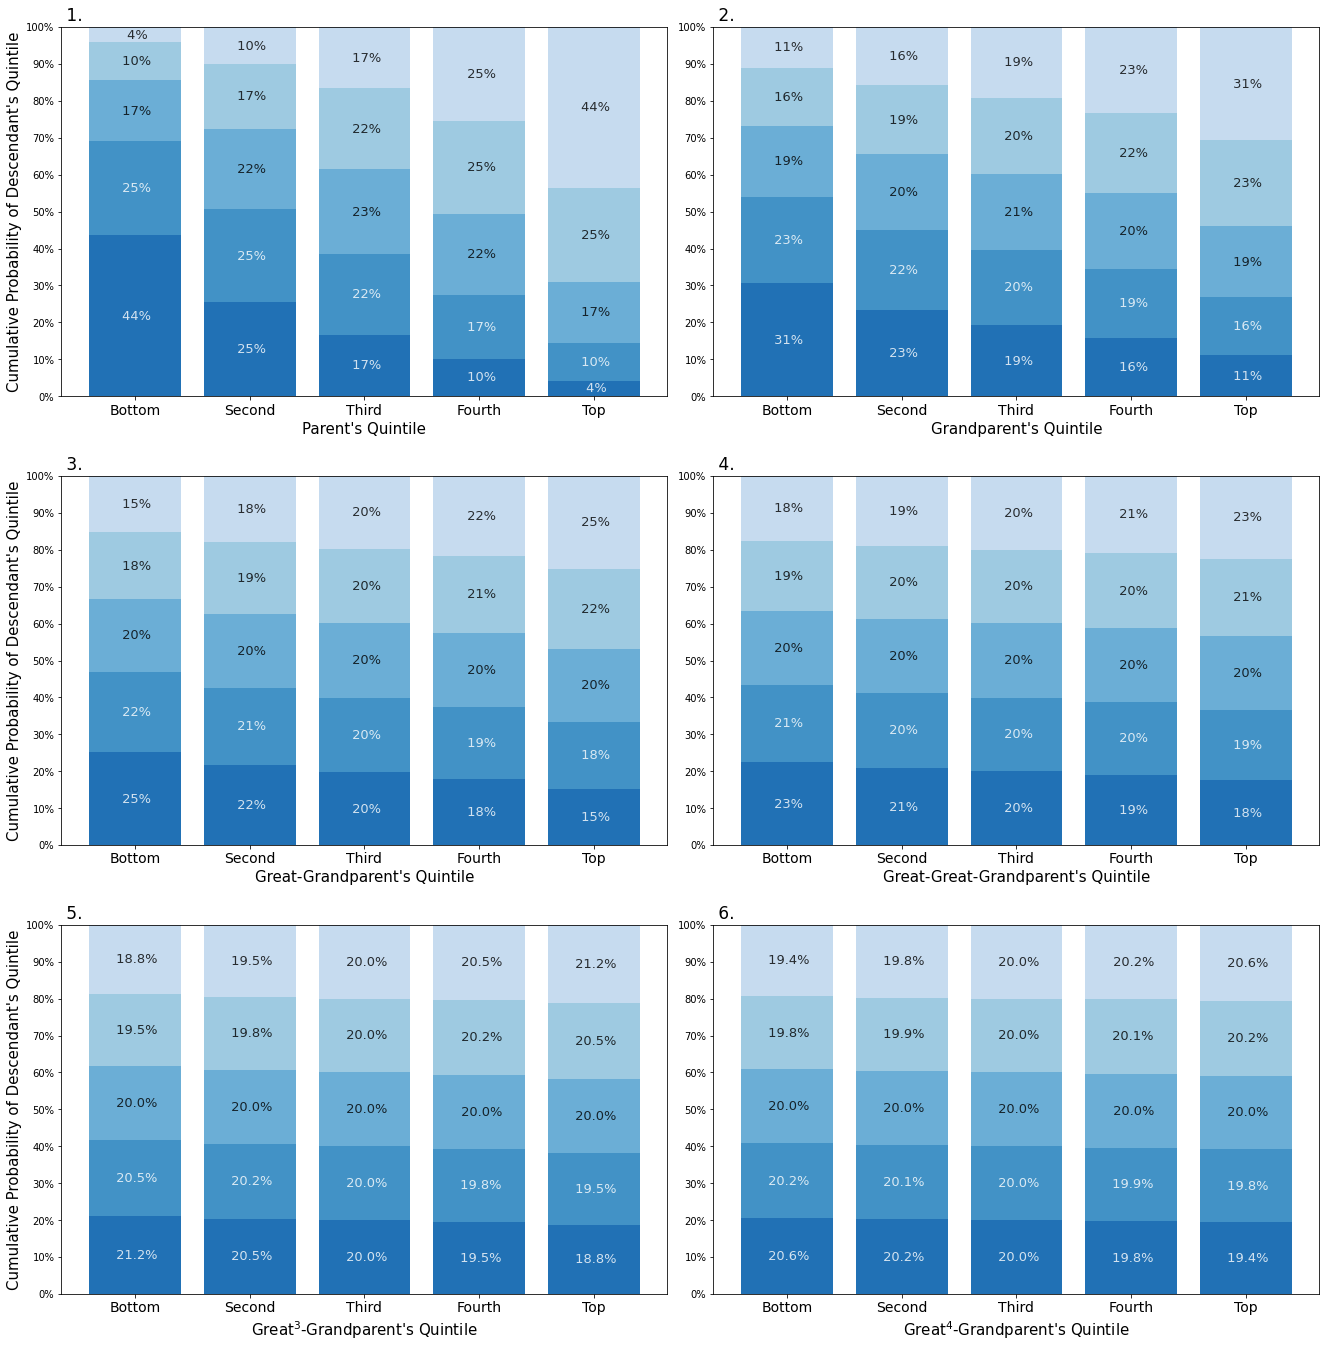

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(13*2*0.95*0.75, 8*3/0.95*0.75))

for i in range(num_steps):
    pk.plot_ax(ax=axes.ravel()[i], matrix=matrices[i], i=i, j=i, 
               title=" {}.".format(str(i+1)), x_label=True, child=False)

# fig.legend(legend, loc="center right", fontsize=15)   

plt.tight_layout()
plt.savefig('latex/figures/quintile-r=0.5-stable.png', dpi=300)
plt.show()

### Mobility measure

In [9]:
mv = np.array([12, 6, 3, 2, 1.4, 1])
m = mv.size

rv = 1 / np.sqrt(mv**2 + 1)
rsv = pk.stable_rs(rv)

matrices_m = [None] * m

In [10]:
%%time
for i in range(m):
    matrices_m[i] = pk.get_matrix(r=rv[i], rs=rsv[i], n=1, num_iters=1_000_000, low_round=6,
                            n_subs0=5, n_subs1=5)

CPU times: user 16 s, sys: 5.29 s, total: 21.3 s
Wall time: 21.3 s


There are `num_iters` number of iterations over the simulated integral for each probability calculation. Therefore, $5\times 5 \times$ `num_iters` total for one quintile transition matrix. Here we make six matrices in 23 seconds. Therefore, about 6.5 million computations per second - due to vectorization. 

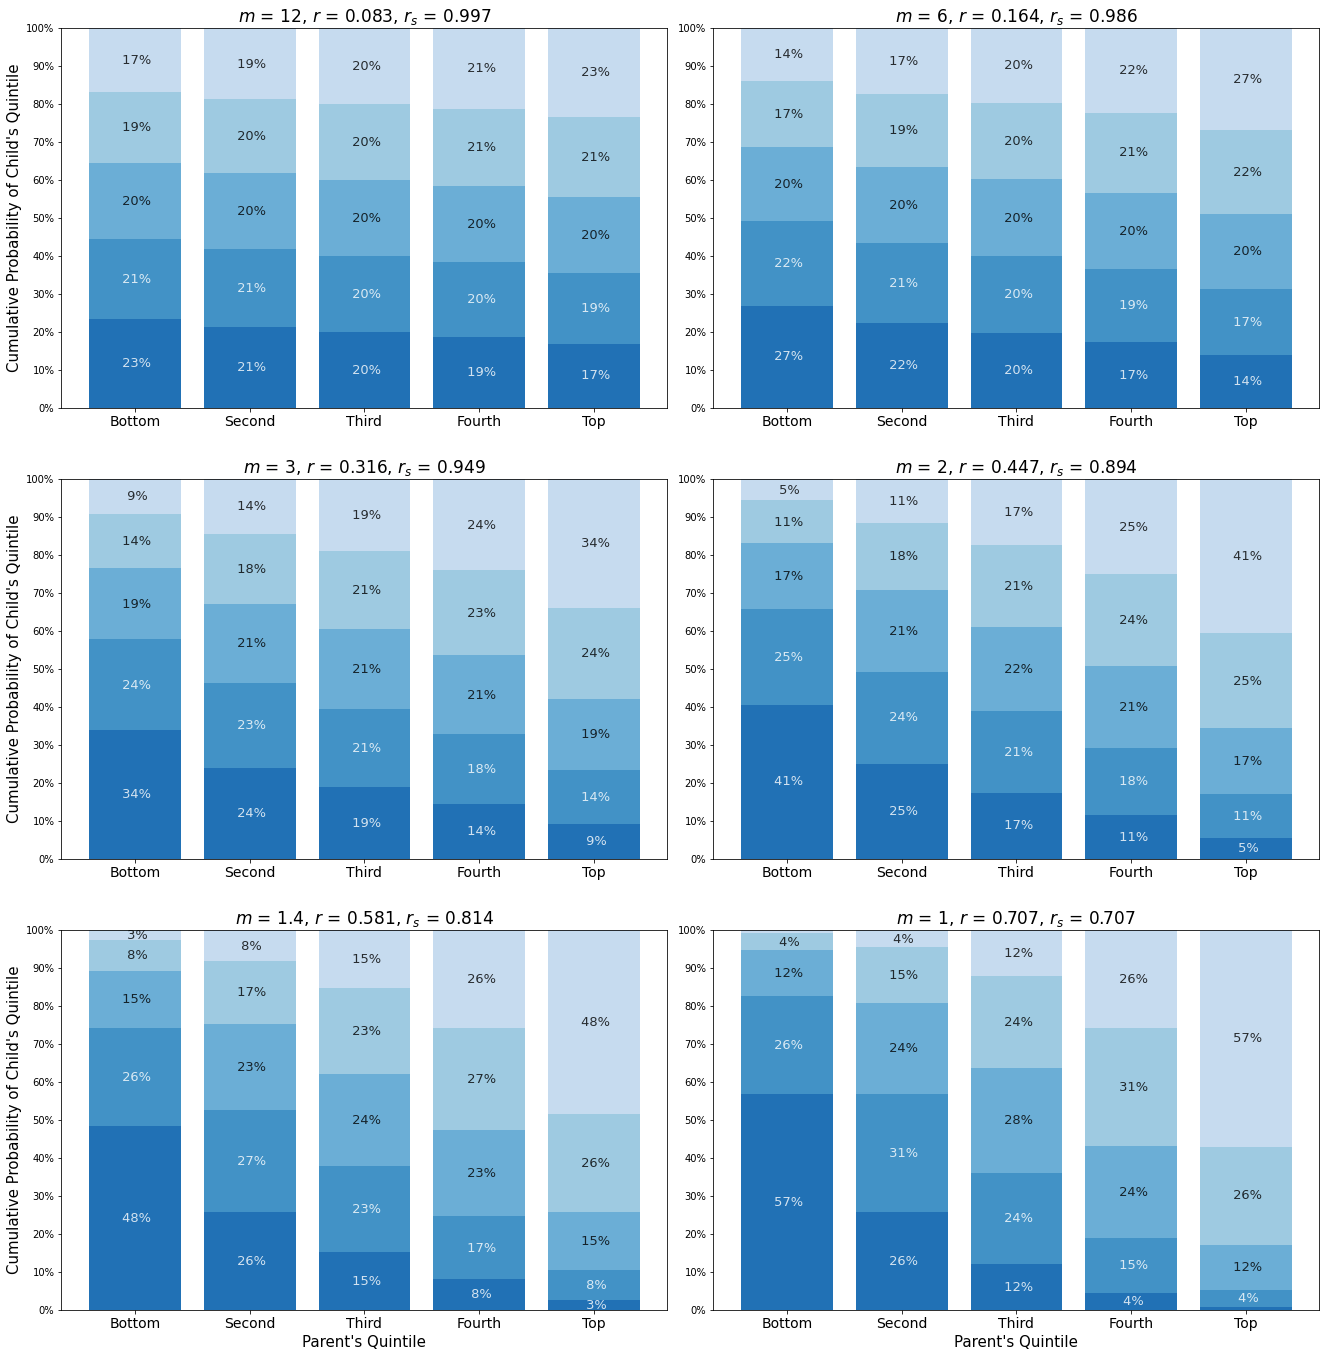

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(13*2*0.95*0.75, 8*3/0.95*0.75))

for i in range(m):
    pk.plot_ax(ax=axes.ravel()[i], matrix=matrices_m[i], i=0, j=i, 
               title=pk.report_mobility(mv, rv, rsv, i), title_loc='center', 
               x_label=False, child=True)

plt.tight_layout()
plt.savefig('latex/figures/quintile-mobility.png', dpi=300)
plt.show()

### Chetty numbers

![](misc/chetty-picture.png)

In [12]:
chetty = np.array(
    [[0.337, 0.242, 0.178, 0.134, 0.109],
    [0.28, 0.242, 0.198, 0.16, 0.119],
     [0.184, 0.217, 0.221, 0.209, 0.17],
     [0.123, 0.176, 0.22, 0.244, 0.236],
     [0.075, 0.123, 0.183, 0.254, 0.365]])

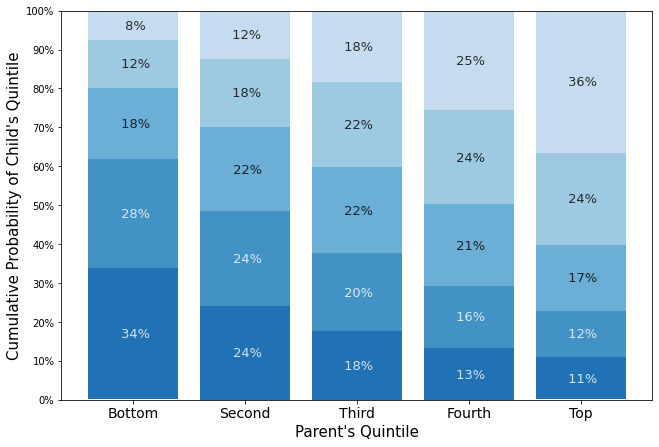

In [13]:
pk.plot_matrix(chetty, child=True, legend=False)
plt.tight_layout()
plt.savefig('latex/figures/quintile-chetty.png', dpi=300)

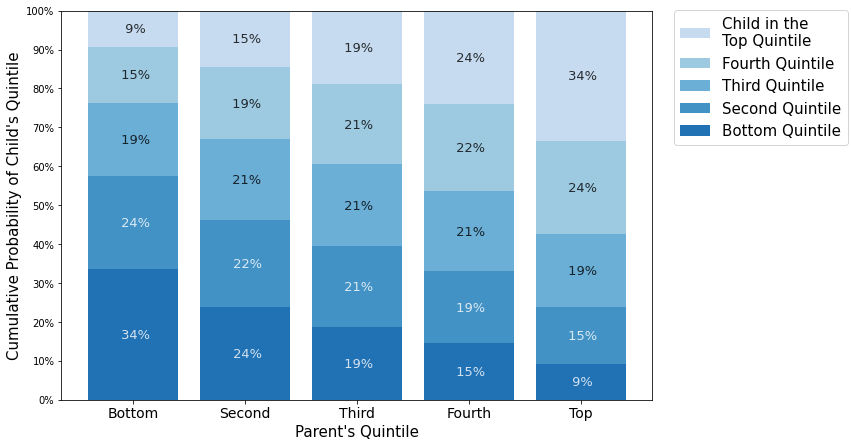

In [14]:
r_chetty = 0.31
pk.plot_matrix(pk.get_matrix(r=r_chetty, rs=pk.stable_rs(r_chetty), n=1, num_iters=40_000, low_round=6,
                            n_subs0=5, n_subs1=5))

In [15]:
pk.stable_rs(r_chetty) / r_chetty

3.06689211797015

### Reference

In [16]:
r_ref = 0.5
ref = pk.get_matrix(r=r_ref, rs=pk.stable_rs(r_ref), n=3, num_iters=1_000_000, low_round=6)

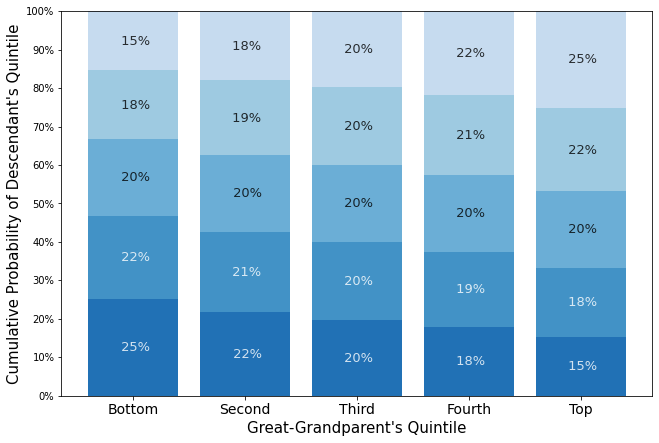

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(13*1*0.95*0.75, 8*1/0.95*0.75))
pk.plot_ax(axes, matrix=ref, i=2, j=2, x_label=True, child=False)
plt.tight_layout()
plt.savefig("latex/figures/quintile_reference.png", dpi=300)

#### Symmetry

In [18]:
def get_sigma(r, rs, n):
    return np.sqrt((r**2+rs**2)**n)


def joint(v1, v2, r, rs, n):
    return st.norm.pdf(v2, 
            scale=pk.sigma_tilda(1, r, rs, n), 
            loc=pk.mu_tilda(v1, r, n)) * st.norm.pdf(v1)


def check_vs(va, vb, r, rs, n):
    va_vb = joint(va, vb, r, rs, n)
    vb_va = joint(vb, va, r, rs, n)
    return va_vb, vb_va

In [19]:
# Stable population variance
r_c = 0.3
check_vs(va=0.3, vb=0.7, r=r_c, rs=pk.stable_rs(r_c), n=3)

(0.11978583233517386, 0.11978583233517384)

In [20]:
# (Not) stable population variance
check_vs(va=0.3, vb=0.7, r=r_c, rs=0.7, n=3)

(0.1007299122787149, 0.2305780215366266)

In [21]:
pa = 0.17
pb = 0.64

In [22]:
def per_to_v1(p1):
    return st.norm.ppf(p1)

In [23]:
def per_to_v2(p2, r, rs, n):
    return st.norm.ppf(p2, scale=get_sigma(r, rs, n))

In [24]:
def check_ps(pa, pb, r, rs, n):
    va_vb = joint(per_to_v1(pa), per_to_v2(pb, r, rs, n), r, rs, n)
    vb_va = joint(per_to_v1(pb), per_to_v2(pa, r, rs, n), r, rs, n)
    
    return va_vb, vb_va

In [25]:
# (Not) stable population variance, but index by percentile
check_ps(pa=0.17, pb=0.64, r=r_c, rs=0.7, n=3)

(0.20986099780993217, 0.20986099780993211)

### Pearson summary stats

In [26]:
rawm = pk.get_matrix_data(xm, ym, return_raw=True)
rawf = pk.get_matrix_data(xf, yf, return_raw=True)

In [27]:
raws = np.ravel((rawm + rawf) / 2)

In [28]:
np.quantile(raws, (0.25, 0.5, 0.75))

array([36. , 47.5, 62. ])

In [29]:
min(np.min(rawm), np.min(rawf))

10.0

In [30]:
max(np.max(rawm), np.max(rawf))

121.0

In [31]:
np.mean(raws)

49.06

### Top two quintiles

In [32]:
# Stature
100-(25+25+43+25)/2

41.0

In [33]:
# Income
100-(25+24+36+24)/2

45.5

### Archive

In [34]:
# r2v = np.arange(0.05, 0.6, 0.1)
# rv = np.sqrt(r2v)
# rsv = pk.stable_rs(rv)
# mv = rsv / rv

In [35]:
# for r in np.arange(0.2, 0.9, 0.1):
    
#     plot_matrix(get_matrix(r=r, rs=stable_rs(r)))
#     plt.title(str(round(r, 2)) + ', ' + str(round(stable_rs(r), 2)) + ', ' + str(round(stable_rs(r) / r, 2)))
#     plt.show()